In [4]:
from google.colab import drive
drive.mount('/content/MyDrive/', force_remount=True)


Mounted at /content/MyDrive/


In [5]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
tf.config.experimental.set_visible_devices(tf.config.experimental.list_physical_devices('GPU')[0], 'GPU')

Num GPUs Available:  1


In [6]:
!pip install split-folders

In [13]:
import numpy as np
import pandas as pd
import tensorflow as tf
import splitfolders
import matplotlib.pyplot as plt
import seaborn as sb
import os
from keras.models import Sequential
from keras.applications import Xception
from keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [10]:
%cd /content/MyDrive/MyDrive/Colab Notebooks/

/content/MyDrive/MyDrive/Colab Notebooks


In [15]:

inputFolder = './image_dataset_(Brain)'
outputFolder = './image_dataset_(Brain)_output'

In [16]:
splitfolders.ratio(inputFolder, outputFolder, seed=44, ratio=(0.8, 0.0, 0.2))

Copying files: 0 files [00:00, ? files/s]


In [17]:
IMGSIZE = 299  # Xception
BATCH_SIZE = 32

In [18]:
trainFolder = os.path.join(inputFolder, 'train')
testFolder = os.path.join(inputFolder, 'test')


train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    shear_range=0.1,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    trainFolder,
    target_size=(IMGSIZE, IMGSIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    testFolder,
    target_size=(IMGSIZE, IMGSIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 16010 images belonging to 4 classes.
Found 4040 images belonging to 4 classes.


In [ ]:
base_model = Xception(weights='imagenet', include_top=False, input_shape=(IMGSIZE, IMGSIZE, 3))

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Freeze base model layers
base_model.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    BatchNormalization(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(train_generator.num_classes, activation='softmax')
])


model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ (None, 10, 10, 2048)   │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,132,460 (80.61 MB)

 Trainable params: 266,884 (1.02 MB)

 Non-trainable params: 20,865,576 (79.60 MB)

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

In [ ]:
history = model.fit(
    train_generator,
    epochs=5,
    validation_data=test_generator,
    callbacks=[early_stop, checkpoint]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
501/501 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.8094 - loss: 0.5864

501/501 ━━━━━━━━━━━━━━━━━━━━ 5669s 11s/step - accuracy: 0.8095 - loss: 0.5861 - val_accuracy: 0.9530 - val_loss: 0.1238
Epoch 2/5
501/501 ━━━━━━━━━━━━━━━━━━━━ 0s 856ms/step - accuracy: 0.9011 - loss: 0.2790

501/501 ━━━━━━━━━━━━━━━━━━━━ 462s 923ms/step - accuracy: 0.9011 - loss: 0.2789 - val_accuracy: 0.9634 - val_loss: 0.1065
Epoch 3/5
501/501 ━━━━━━━━━━━━━━━━━━━━ 0s 828ms/step - accuracy: 0.9159 - loss: 0.2217

501/501 ━━━━━━━━━━━━━━━━━━━━ 489s 895ms/step - accuracy: 0.9159 - loss: 0.2217 - val_accuracy: 0.9710 - val_loss: 0.0856
Epoch 4/5
501/501 ━━━━━━━━━━━━━━━━━━━━ 0s 852ms/step - accuracy: 0.9256 - loss: 0.2012

501/501 ━━━━━━━━━━━━━━━━━━━━ 514s 920ms/step - accuracy: 0.9255 - loss: 0.2012 - val_accuracy: 0.9757 - val_loss: 0.0747
Epoch 5/5
501/501 ━━━━━━━━━━━━━━━━━━━━ 0s 845ms/step - accuracy: 0.9343 - loss: 0.1873

501/501 ━━━━━━━━━━━━━━━━━━━━ 457s 912ms/step - accuracy: 0.9343 - loss: 0.1873 - val_accuracy: 0.9725 - val_loss: 0.0711


In [11]:
from tensorflow.keras.models import load_model
model = load_model('best_model.h5')

In [19]:
loss, accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {accuracy * 100:.2f}%")


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


127/127 ━━━━━━━━━━━━━━━━━━━━ 1116s 9s/step - accuracy: 0.9735 - loss: 0.0679
Test Accuracy: 97.25%


127/127 ━━━━━━━━━━━━━━━━━━━━ 42s 308ms/step
Classification Report
                 precision    recall  f1-score   support

   brain_glioma       0.97      1.00      0.98      1010
    brain_menin       0.98      0.91      0.95      1010
brain_pituitary       0.94      0.98      0.96      1010
       no_tumor       1.00      1.00      1.00      1010

       accuracy                           0.97      4040
      macro avg       0.97      0.97      0.97      4040
   weighted avg       0.97      0.97      0.97      4040



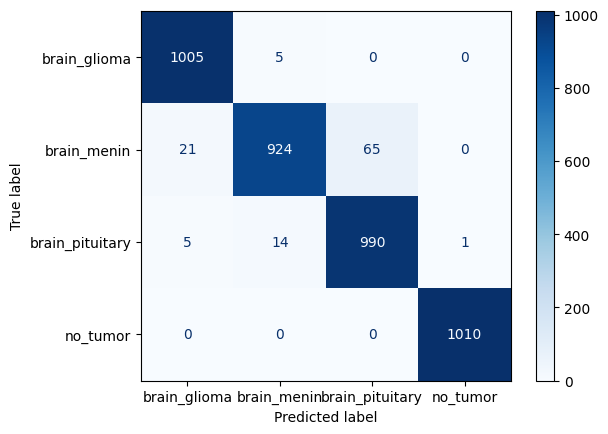

In [20]:
import numpy as np

Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

print('Classification Report')
print(classification_report(test_generator.classes, y_pred, target_names=list(test_generator.class_indices.keys())))

cm = confusion_matrix(test_generator.classes, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(test_generator.class_indices.keys()))
disp.plot(cmap=plt.cm.Blues)
plt.show()

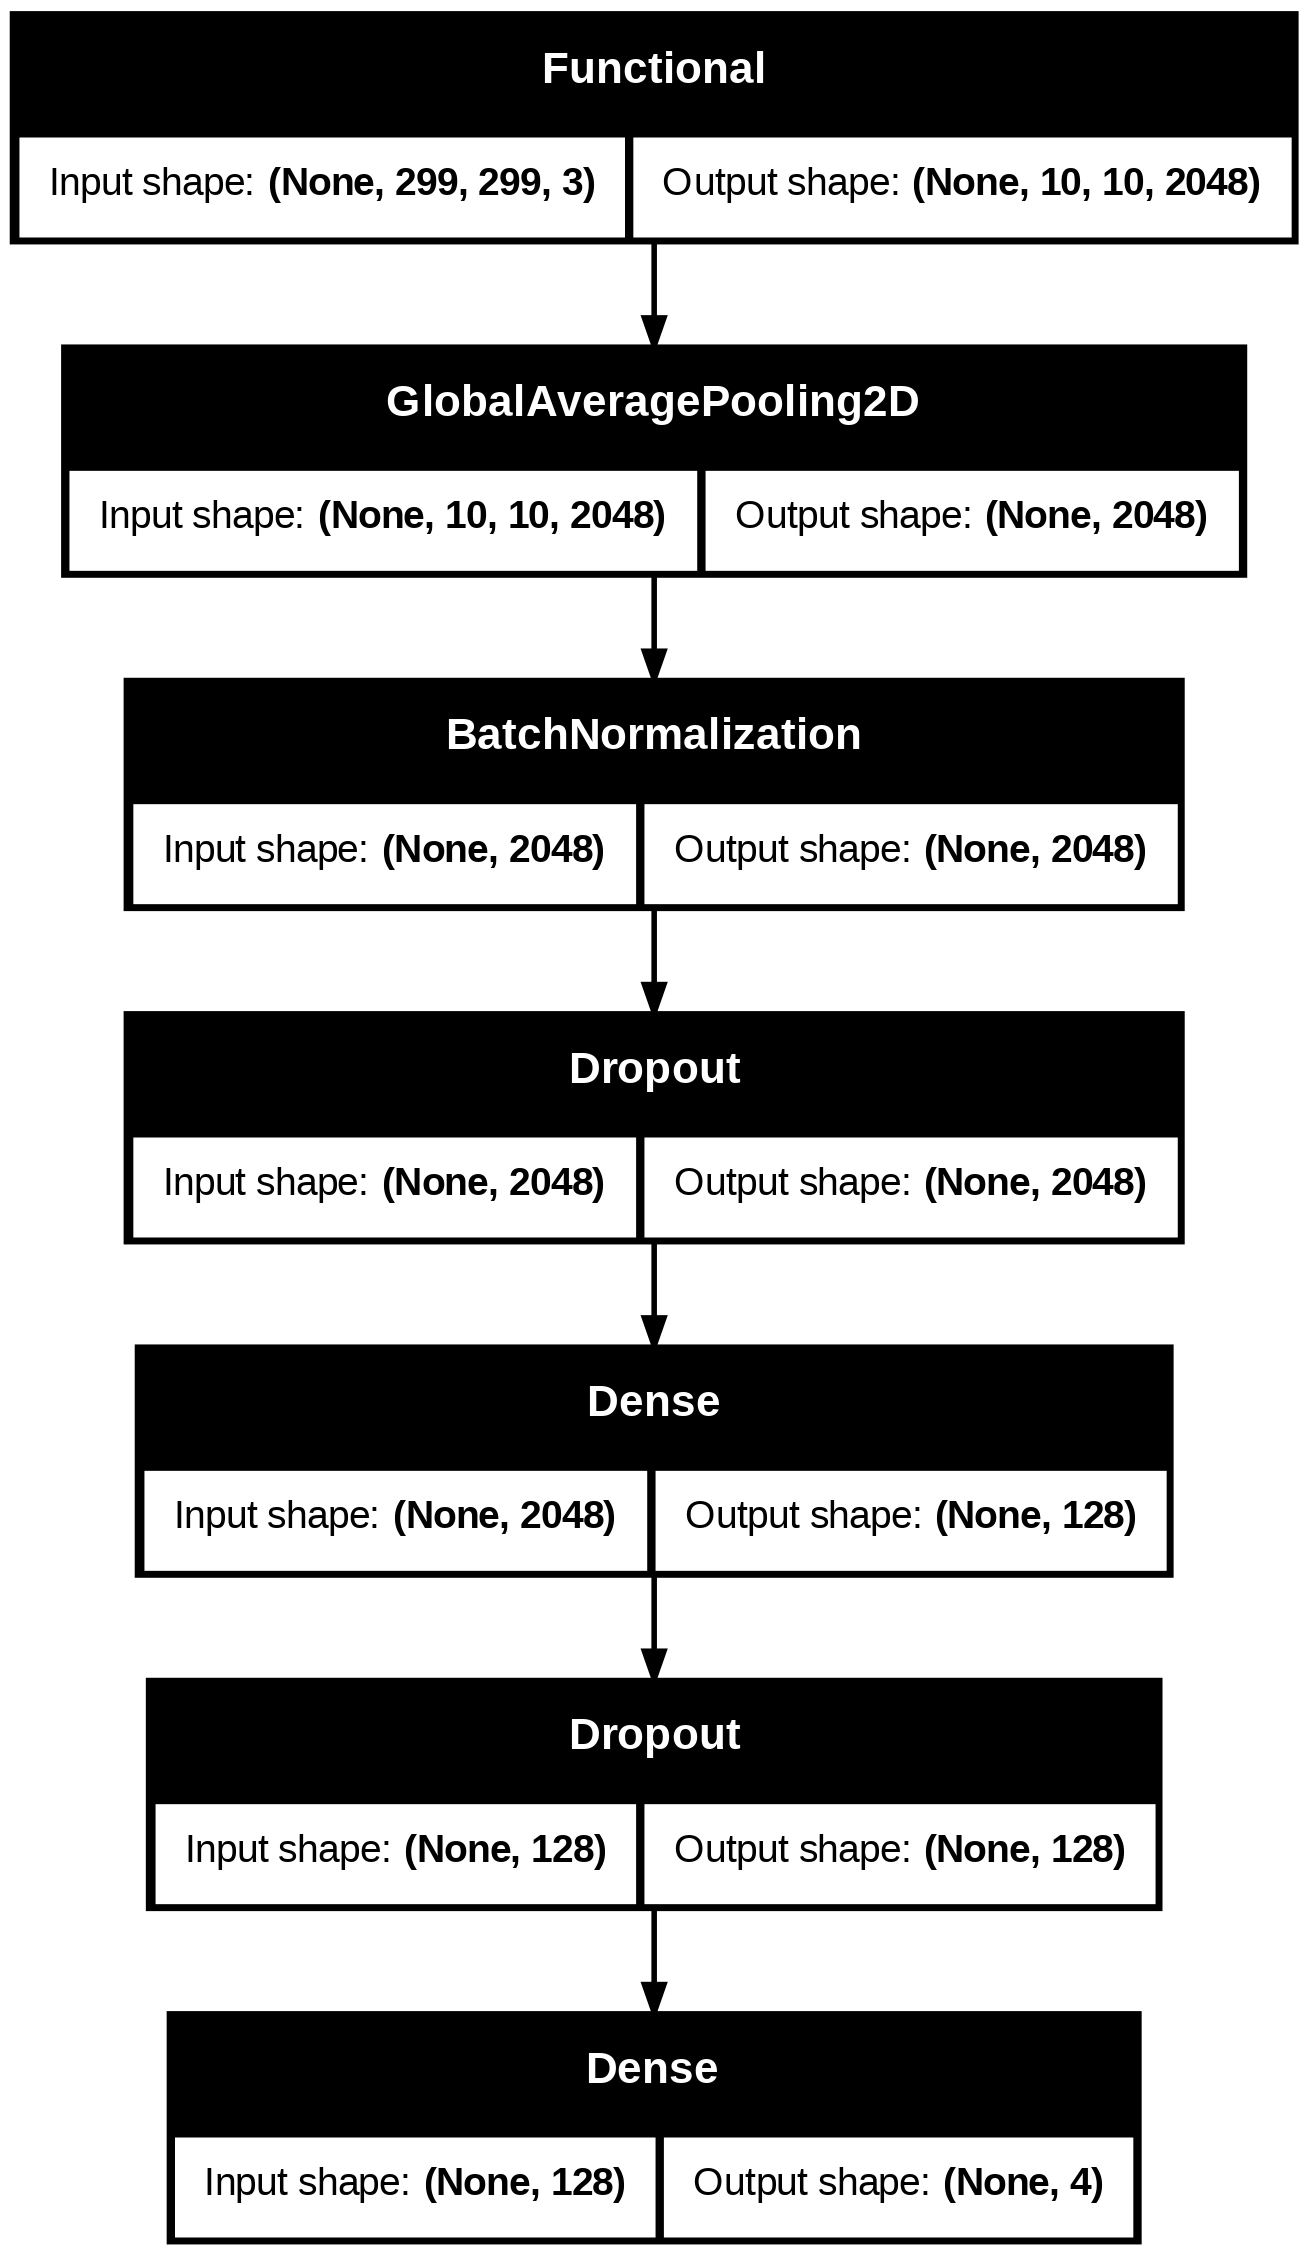

In [24]:
from keras.utils import plot_model
plot_model(model, show_shapes = True)

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(model.history['accuracy'], label='Train Accuracy')
plt.plot(model.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(model.history['loss'], label='Train Loss')
plt.plot(model.history['val_loss'], label='Validation Loss')
plt.title('Loss over epochs')
plt.legend()

plt.show()